# Outline

* Today we will show how to train a ConvNet using PyTorch
* We will also illustrate how the ConvNet makes use of specific assumptions

# To perform well, we need to incorporate some prior knowledge about the problem

* Assumptions helps us when they are true
* They hurt us when they are not
* We want to make just the right amount of assumptions, not more than that

## In Deep Learning

* Many layers: compositionality
* Convolutions: locality + stationarity of images
* Pooling: Invariance of object class to translations

In [1]:
from res.plot_lib import plot_data, plot_model, set_default

In [2]:
set_default()

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy

from torch.utils.tensorboard import SummaryWriter

# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the Dataset (MNIST)


We can use some PyTorch DataLoader utilities for this. This will download, shuffle, normalize data and arrange it in batches.

In [5]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

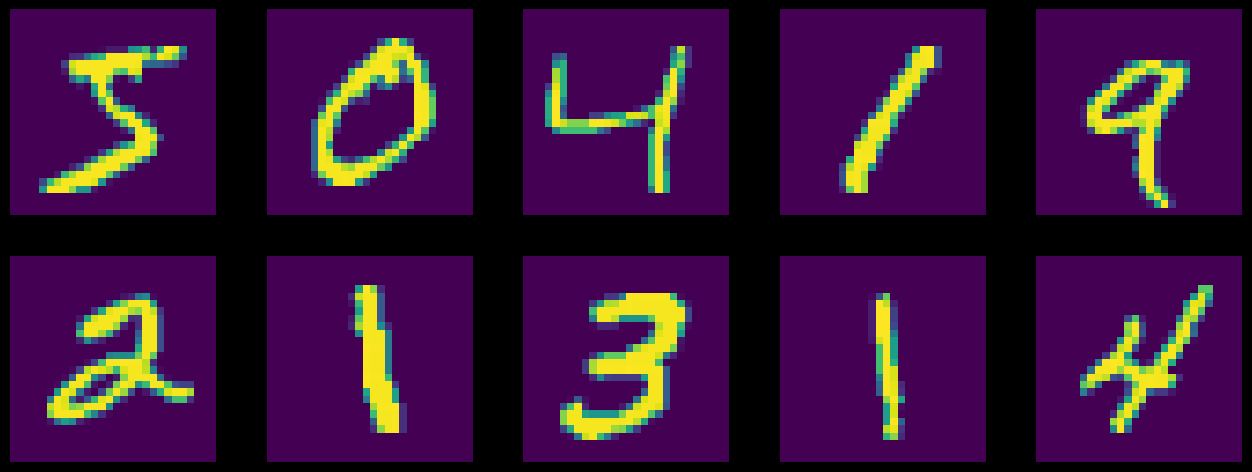

In [6]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

# Create the model classes

In [7]:
class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, output_size),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)

class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

## Running on a GPU: device string

Switching between CPU and GPU in PyTorch is controlled via a device string, which will seemlessly determine whether GPU is available, falling back to CPU if not:

In [8]:
accuracy_list = []

def train(epoch, model, perm=torch.arange(0, 784).long()):
    model.train()
    writer = SummaryWriter()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)

        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
        if (epoch%2 == 0):
            writer.add_scalar('Loss', loss.item(), epoch)
            
            writer.add_scalar('MSE Loss', loss.item(), epoch)
        
        writer.close()

            # Write y_pred and compare to truth
            
#             fig, ax = plt.subplots()
#             ax.plot(data.to(device), output)

#             writer.add_figure('y_pred', fig, epoch, close=True)
#             plt.close(fig)

#             writer.add_graph(model, data)
#             writer.add_hparams({'lr': lr}, {'loss':loss.item()})
         
        

def test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)

        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

# Train a small fully-connected network

In [9]:
# n_hidden = 8 # number of hidden units

# model_fnn = FC2Layer(input_size, n_hidden, output_size)
# model_fnn.to(device)
# optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
# print('Number of parameters: {}'.format(get_n_params(model_fnn)))

# for epoch in range(0, 1):
#     train(epoch, model_fnn)
#     test(model_fnn)

# Train a ConvNet with the same number of parameters

In [10]:
# Training settings
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn)
    test(model_cnn)



Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.294356
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.035341
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.651005
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.269469
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.474528
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.231941
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.133337
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.419046
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.185819
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.237893

Test set: Average loss: 0.1469, Accuracy: 9580/10000 (96%)



In [11]:
%load_ext tensorboard
%tensorboard --logdir runs/

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Traceback (most recent call last):
  File "/Users/petern/miniconda3/envs/pan-theory/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/Users/petern/miniconda3/envs/pan-theory/lib/python3.8/site-packages/tensorboard/main.py", line 65, in run_main
    default.get_plugins(),
  File "/Users/petern/miniconda3/envs/pan-theory/lib/python3.8/site-packages/tensorboard/default.py", line 108, in get_plugins
    return get_static_plugins() + get_dynamic_plugins()
  File "/Users/petern/miniconda3/envs/pan-theory/lib/python3.8/site-packages/tensorboard/default.py", line 143, in get_dynamic_plugins
    return [
  File "/Users/petern/miniconda3/envs/pan-theory/lib/python3.8/site-packages/tensorboard/default.py", line 144, in <listcomp>
    entry_point.load()
  File "/Users/petern/miniconda3/envs/pan-theory/lib/python3.8/site-packages/pkg_resources/__init__.py", line 2471, in load
    self.require(*args, **kwa

# The ConvNet performs better with the same number of parameters, thanks to its use of prior knowledge about images

* Use of convolution: Locality and stationarity in images
* Pooling: builds in some translation invariance

# What happens if the assumptions are no longer true?


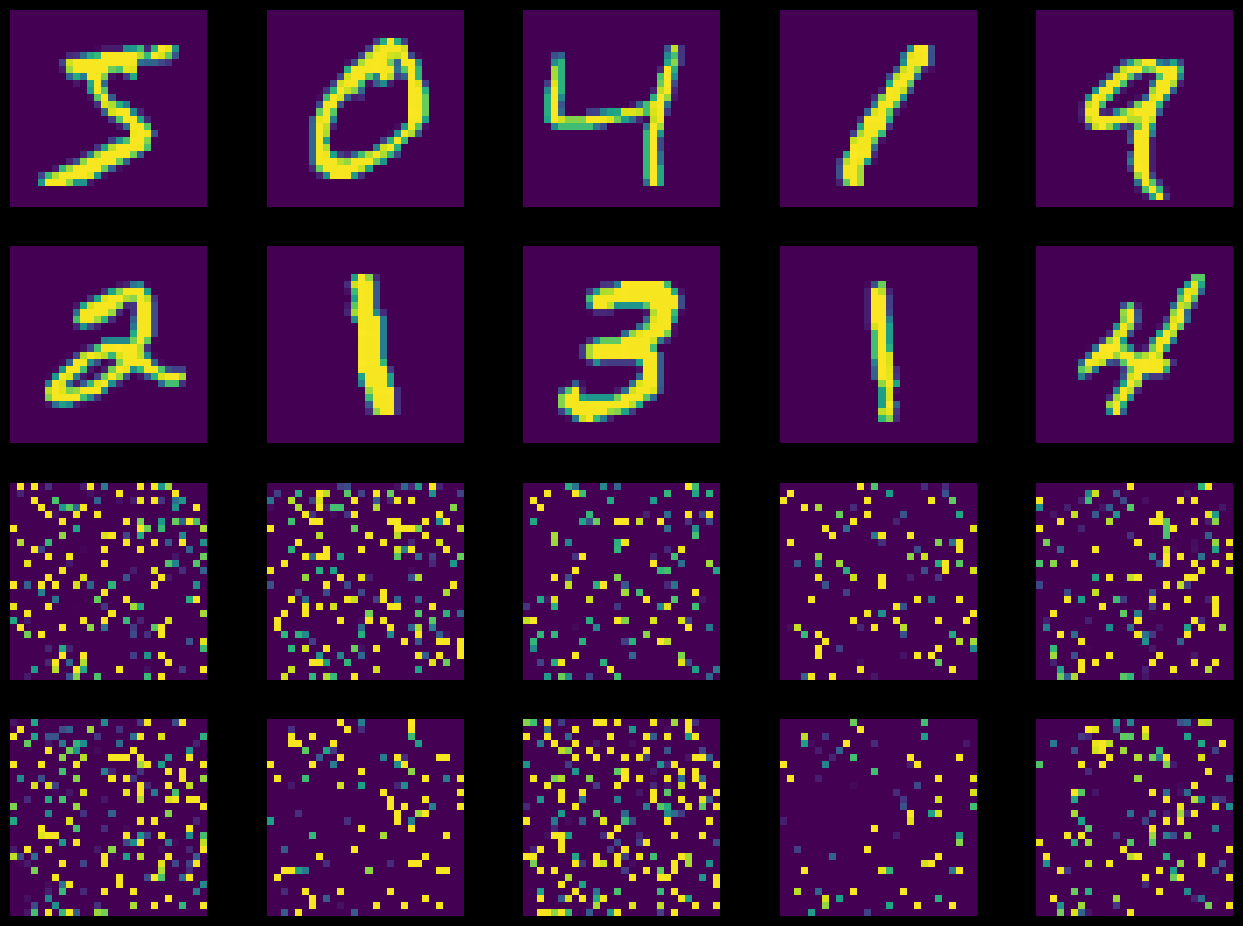

In [12]:
perm = torch.randperm(784)
plt.figure(figsize=(16, 12))
for i in range(10):
    image, _ = train_loader.dataset.__getitem__(i)
    # permute pixels
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')

# ConvNet with permuted pixels

In [13]:
# # Training settings
# n_features = 6 # number of feature maps

# model_cnn = CNN(input_size, n_features, output_size)
# model_cnn.to(device)
# optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
# print('Number of parameters: {}'.format(get_n_params(model_cnn)))

# for epoch in range(0, 1):
#     train(epoch, model_cnn, perm)
#     test(model_cnn, perm)

# Fully-Connected with Permuted Pixels

In [14]:
# n_hidden = 8    # number of hidden units

# model_fnn = FC2Layer(input_size, n_hidden, output_size)
# model_fnn.to(device)
# optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
# print('Number of parameters: {}'.format(get_n_params(model_fnn)))

# for epoch in range(0, 1):
#     train(epoch, model_fnn, perm)
#     test(model_fnn, perm)

# The ConvNet's performance drops when we permute the pixels, but the Fully-Connected Network's performance stays the same

* ConvNet makes the assumption that pixels lie on a grid and are stationary/local
* It loses performance when this assumption is wrong
* The fully-connected network does not make this assumption
* It does less well when it is true, since it doesn't take advantage of this prior knowledge
* But it doesn't suffer when the assumption is wrong

In [15]:
# plt.bar(('NN image', 'CNN image',
#          'CNN scrambled', 'NN scrambled'),
#         accuracy_list, width=0.4)
# plt.ylim((min(accuracy_list)-5, 96))
# plt.ylabel('Accuracy [%]')
# for tick in plt.gca().xaxis.get_major_ticks():
#     tick.label.set_fontsize(20)
# plt.title('Performance comparison');

### Checking Model Parameters

In [16]:
# print(dir(model_cnn))

In [17]:
# print(dir(model_fnn))